In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as pl
import pandas as pd
from scipy.interpolate import UnivariateSpline as spline
from scipy.stats import gaussian_kde as kde

Read in the recovery data for either the nominal ARF or non-nominal arfs:

In [78]:
rec_pca=pd.read_csv('recov_cnn.csv',index_col=0)

Plot the G recovery:

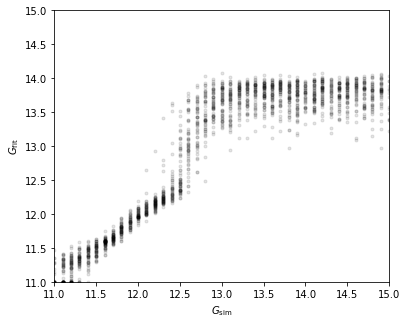

In [61]:
def plot_recov(data):
    fig=pl.figure(figsize=(6,5),facecolor='w')
    ax=pl.subplot(111)
    ax.set_xlabel(r'$G_\mathrm{sim}$')
    ax.set_ylabel(r'$G_\mathrm{fit}$')
    ax.set_xlim(11,15)
    ax.set_ylim(11,15)
    pl.plot(data['g_sim'],data['g_fit'],marker='.',ls='none',color='k',alpha=0.1)
    return fig, ax

plot_recov(rec_pca)
pl.show()

1:1 line where recovery is good, points clustered around G = 14 (~ the middle of the none-detection parameter space) when recovery is bad.

95% limit means that if we input a spectrum and the ANN says there is no evidence for axions (G_fit>G_threshold), we can be 95% confident that the true value of G (i.e. G_sim) is above that limit, i.e. there is a 5% chance that G_sim is < G_limit, with no prior on what G actually is.

First determine a non-detection threshold, by plotting the distribution of definite non-detections:

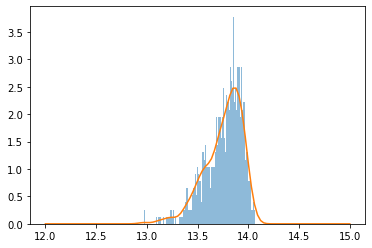

In [5]:
# plot histogram
pl.hist(rec_pca['g_fit'][rec_pca['g_sim']>13.5],bins=100,alpha=0.5,density=True)

# define kernel density estimate
density=kde(rec_pca['g_fit'][rec_pca['g_sim']>13.5])
gs=np.linspace(12,15,100)
pl.plot(gs,density.pdf(gs))

pl.show()

If we define a non-detection threshold as the 99% lower limit of this distribution, we can find this from the CDF:

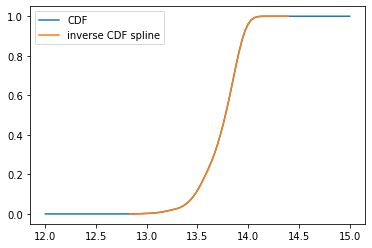

G_threshold: 13.152573115278184


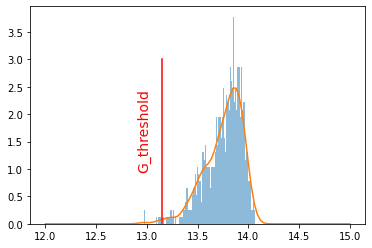

In [6]:
cdf=np.cumsum(density.pdf(gs))
cdf=cdf/max(cdf)

pl.plot(gs,cdf,label='CDF')

# invert the CDF to find the 0.001% percentile:
inv_cdf=spline(cdf[(cdf>1e-5) &  (cdf<1)],gs[(cdf>1e-5) &  (cdf<1)],s=0)
pl.plot(inv_cdf(cdf),cdf,label='inverse CDF spline')

pl.legend()
pl.show()

FA_prob=0.01

G_threshold=inv_cdf(FA_prob)
print('G_threshold:',G_threshold)


pl.hist(rec_pca['g_fit'][rec_pca['g_sim']>13.5],bins=100,alpha=0.5,density=True)
pl.plot(gs,density.pdf(gs))
pl.plot([G_threshold,G_threshold],[0,3],color='r')
pl.text(12.9,1,'G_threshold',color='r',fontsize=14,rotation=90)

pl.show()

We can plot this limit on the graph, check it makes sense. Note that this is not our 95% upper limit, this is the threshold we are using for detections/non-detections.

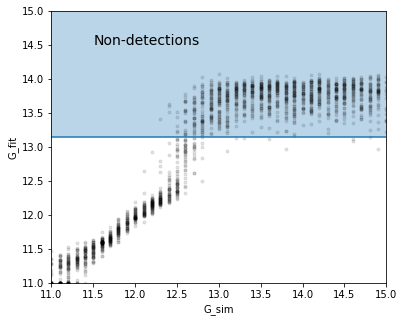

In [7]:
plot_recov(rec_pca)
pl.plot([11,15],[G_threshold,G_threshold])
pl.fill_between([11,15],[G_threshold,G_threshold],[15,15],alpha=0.3)
pl.text(11.5,14.5,'Non-detections',fontsize=14)
pl.show()

Now, we can calculate the posterior distribution of G_sim, given that G_fit>G_threshold:

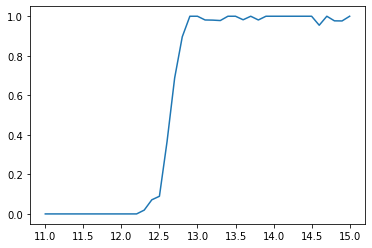

In [8]:

# find the set of G_sim values:
g_sim_vals=np.array(sorted(list(set(rec_pca['g_sim']))))

fractions=[]
for g_sim in g_sim_vals:
    fractions.append(len(rec_pca['g_sim'][(rec_pca['g_fit']>G_threshold) & (rec_pca['g_sim']==g_sim)])/len(rec_pca['g_sim'][(rec_pca['g_sim']==g_sim)]))

pl.plot(g_sim_vals,fractions)
pl.show()

    


Find the mean fraction for G>13.5, then extrapolate that down to G=19

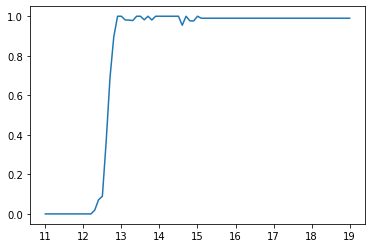

In [77]:
f_extr=1-FA_prob

G_terminal=19

Nsteps=int((G_terminal-15)/0.1)

new_fractions=[f_extr]*Nsteps
new_steps=np.linspace(15.1,G_terminal,Nsteps)

fractions_extr=fractions+new_fractions
g_sim_extr=np.concatenate((g_sim_vals,new_steps))

pl.plot(g_sim_extr,fractions_extr)

Calculate cumulative distribution, find 5th percentile:

12.904777551677023 12.50531904135964


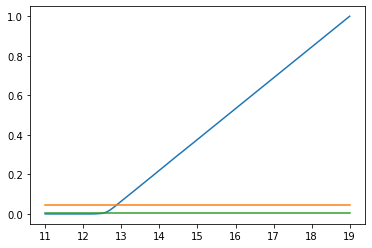

In [10]:
fractions_cdf=np.cumsum(fractions_extr)
fractions_cdf=fractions_cdf/max(fractions_cdf)
pl.plot(g_sim_extr,fractions_cdf)
pl.plot([11,19],[0.045,0.045])
pl.plot([11,19],[0.003,0.003])

intersect_spline95=spline(g_sim_extr,fractions_cdf-0.05,s=0)
intersect_spline997=spline(g_sim_extr,fractions_cdf-0.003,s=0)
intersect_spline99=spline(g_sim_extr,fractions_cdf-0.01,s=0)
confidence_limit95=intersect_spline95.roots()[0]
confidence_limit997=intersect_spline997.roots()[0]
confidence_limit99=intersect_spline99.roots()[0]

print(confidence_limit95, confidence_limit997)

Make big shiny plot with limits on it:

12.904777551677023 12.615913018301134 12.50531904135964


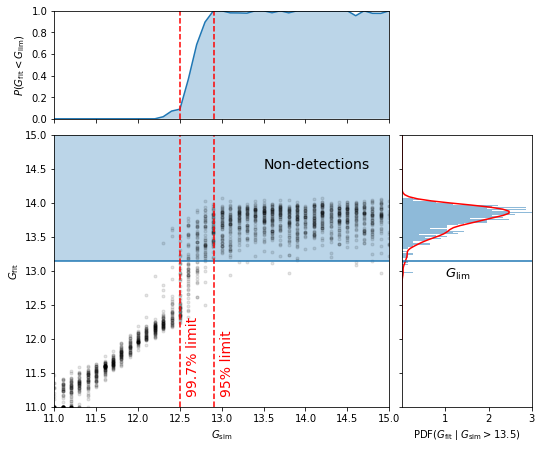

In [76]:
fig,ax=plot_recov(rec_pca)
# ax.set_xlim(11,14.999)
pl.plot([11,15],[G_threshold,G_threshold])
pl.fill_between([11,15],[G_threshold,G_threshold],[15,15],alpha=0.3)
pl.text(13.5,14.5,'Non-detections',fontsize=14)

pl.plot([confidence_limit95,confidence_limit95],[11,15],color='r',ls='dashed')
pl.plot([confidence_limit997,confidence_limit997],[11,15],color='r',ls='dashed')
pl.text(confidence_limit95+0.07,11.2, r'95% limit',fontsize=14,color='r',rotation=90)
pl.text(confidence_limit997+0.07,11.2, r'99.7% limit',fontsize=14,color='r',rotation=90)

# pl.plot([confidence_limit99,confidence_limit99],[12.5,15],color='r',ls='dashed')

axcoords=ax.get_position().bounds

ax2=fig.add_axes([axcoords[0],axcoords[3]+0.17,axcoords[2],0.3])
ax2.set_xlim(11,15)
ax2.set_ylim(0,1)
ax2.set_ylabel(r'$P(G_\mathrm{fit}<G_\mathrm{lim})$')
ax2.set_xticklabels([])
pl.plot(g_sim_extr,fractions_extr)
pl.fill_between(g_sim_extr,fractions_extr,0,alpha=0.3)
pl.plot([confidence_limit95,confidence_limit95],[0,1],color='r',ls='dashed')
pl.plot([confidence_limit997,confidence_limit997],[0,1],color='r',ls='dashed')

#lbwh
ax3=fig.add_axes([axcoords[0]+axcoords[2]+0.03,axcoords[1],0.3,axcoords[3]])
ax3.set_ylim(11,15)
ax3.set_xlim(0.001,3)
ax3.set_yticklabels([])
ax3.set_xlabel(r'PDF$(G_\mathrm{fit} \mid G_\mathrm{sim}>13.5)$')

pl.hist(rec_pca['g_fit'][rec_pca['g_sim']>13.5],bins=100,alpha=0.5,density=True,orientation='horizontal',color='C0')
pl.plot(density.pdf(gs),gs,color='r')
pl.plot([0,3],[G_threshold,G_threshold],color='C0')
pl.text(1,12.9,r'$G_\mathrm{lim}$',color='k',fontsize=13)


pl.savefig('figures/limitplot.png',bbox_inches='tight',dpi=200)

print(confidence_limit95, confidence_limit99, confidence_limit997)